## VAE Hawkes Process Estimation - Tutorial

In [1]:
import os

import numpy as np
import pandas as pd
import scienceplots

import matplotlib.pyplot as plt

from dl.mlp_model import MLPTrainer
import variables.prep_var as prep

from evaluation.eval import compute_errors
from hawkes.simulation import hawkes_simulations
from hawkes.discretisation import discretise
from hawkes.hyperparameters import hyper_params_simulation
from tools.utils import read_parquet, timer
from visualization.error_viz import convergence_rate, errors_boxplots, effects_boxplots
from preprocessing.dataset import split_data, create_datasets, create_data_loaders

%load_ext autoreload
%autoreload 2

### Preprocessing

In [49]:
# Training/Validation/Testing dataset generation

# Intensity Decay Parameter (β) = U(p = 1, q = 3)
# Branching Ratio (η) = U(a = 0.05, b = 0.8)
# Expected Activity (E) = 500
# Time Horizon (T) = 100
# Interval Length (∆) = 1
# Number of processes = 100_000

# Hawkes process hyper-parameters generation
params, alpha, beta, eta, mu = hyper_params_simulation(filename="hawkes_hyperparams.parquet")

# Hawkes processes simulations
simulated_events_seqs = hawkes_simulations(alpha, beta, mu, filename="hawkes_simulations.parquet")

# Discrétiser les processus de Hawkes
discret_simulated_events_seqs = discretise(simulated_events_seqs, filename="binned_hawkes_simulations.parquet")

### Training

In [2]:
# Data Preparation (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

x = read_parquet("br_mlp/binned_hawkes_simulations_train_br_0.2_0.7.parquet")
y = read_parquet("br_mlp/hawkes_hyperparams_train_br_0.2_0.7.parquet")

train_x, train_y, val_x, val_y, test_x, test_y = split_data(x, y[['eta', 'mu']]) 
train_dataset, val_dataset, test_dataset = create_datasets(train_x, train_y, val_x, val_y, test_x, test_y)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

In [3]:
# Trained model

model, train_losses, val_losses, val_y_pred, val_eta, val_mu = MLPTrainer().train_model(train_loader, val_loader, val_x, val_y)
%load_ext tensorboard

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
MLP                                      [10000, 100]              [10000, 2]                --                             --                   --                        --                        True
├─Linear: 1-1                            [10000, 100]              [10000, 100]              10,100                     14.25%                   --                        101,000,000               True
├─ModuleList: 1-2                        --                        --                        --                             --                   --                        --                        True
│    └─Sequential: 2-1                   [10000, 100]              [10000, 100]              --                             --                   --                        --              

Epoch 74/500 - train_loss: 0.1093, val_loss: 0.1090:  15%|█▍        | 74/500 [08:44<51:17,  7.22s/it]  

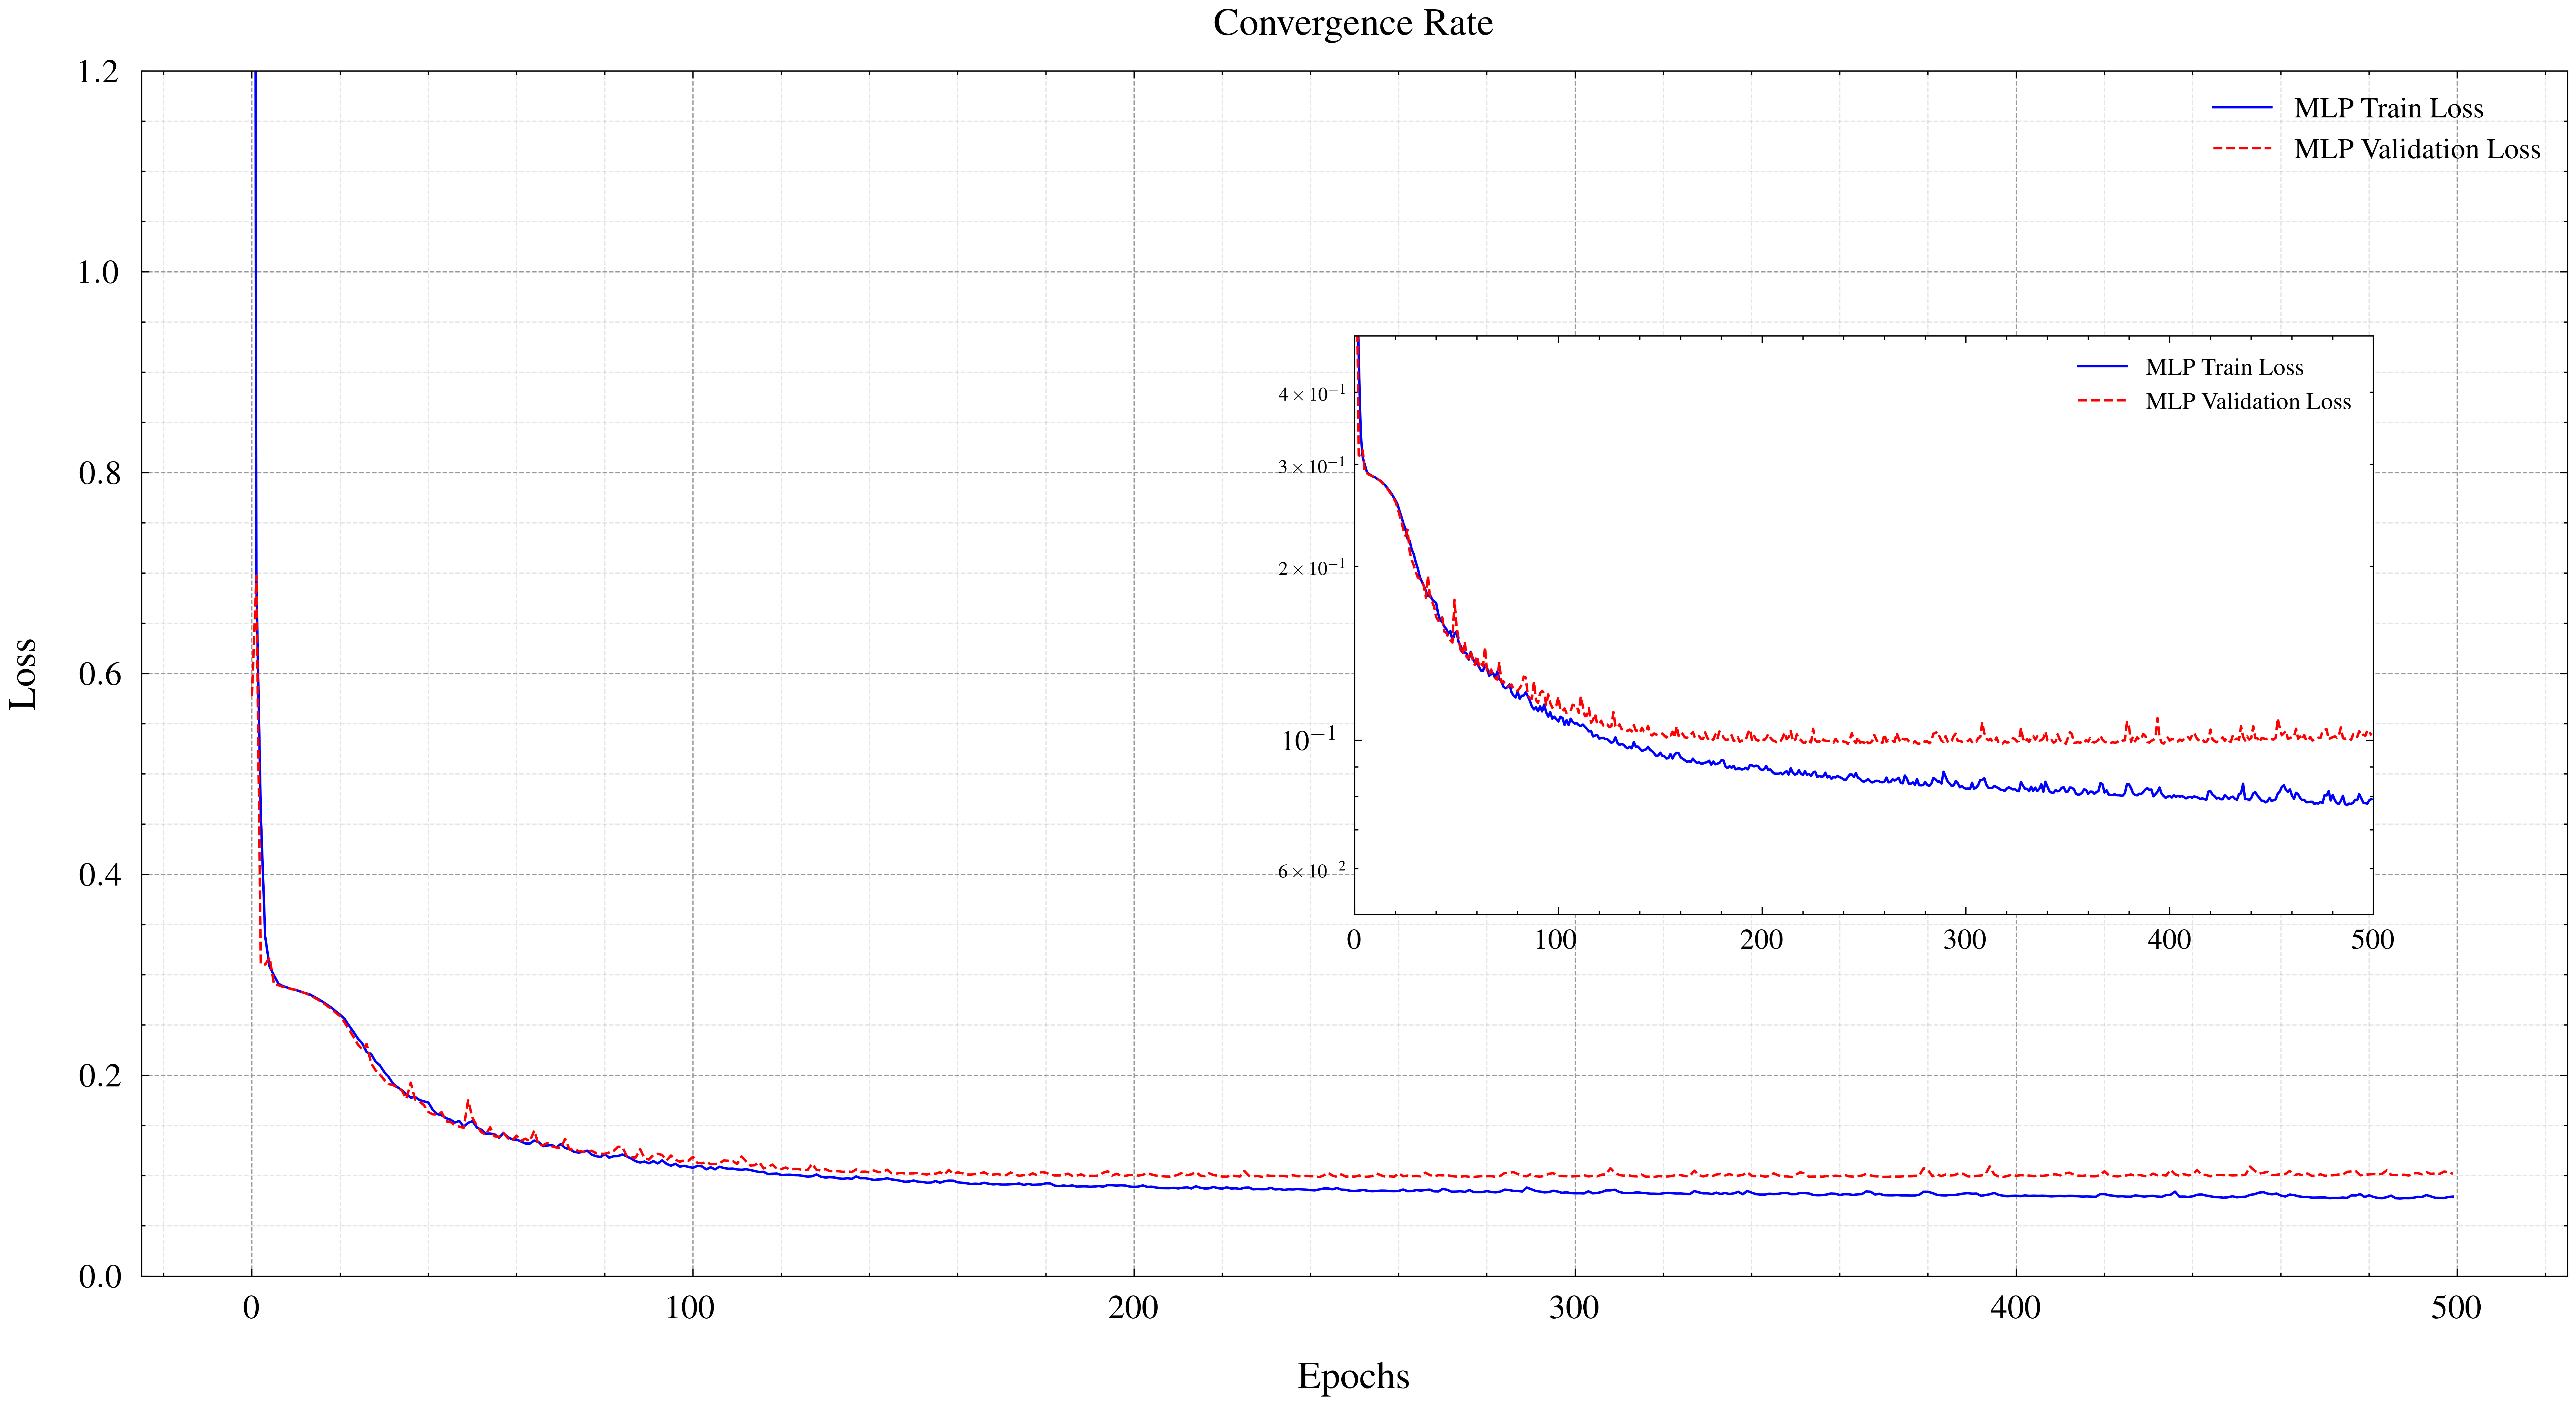

In [4]:
# Convergence rate plots

# bench_losses = read_parquet('benchmark/losses_benchmark.parquet')
mlp_losses = read_parquet('br_mlp/losses_mlp_br_0.2_0.7.parquet')

convergence_rate(losses=[mlp_losses], models=["MLP"], colors=["blue", "red"])

### Testing

In [5]:
# Tested model (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

x = read_parquet("br_mlp/binned_hawkes_simulations_br_0.2_0.7.parquet")
y = read_parquet("br_mlp/hawkes_hyperparams_br_0.2_0.7.parquet")

test_x, test_y, _, _, _, _ = split_data(x, y[['eta', 'mu']])
test_y_pred, _, _ = MLPTrainer().test_model(test_x, test_y)
%load_ext tensorboard

Best model loading (2023_05_20_16_17_46_MICSHPEG8GIRARD_best_model.pt)...
Test set - Estimated branching ratio (η): 0.3459, Estimated baseline intensity (µ): 3.2875
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Evaluation

In [7]:
# Computed absolute/relative error + boxplots

# bench_pred = read_parquet('predictions_benchmark.parquet')
mlp_pred = read_parquet('br_mlp/predictions_mlp_br_0.2_0.7.parquet')

# bench_errors = compute_errors(bench_pred[['eta_true', 'mu_true']], bench_pred[['eta_pred', 'mu_pred']])
mlp_errors = compute_errors(mlp_pred[['eta_true', 'mu_true']], mlp_pred[['eta_pred', 'mu_pred']], model_name='MLP')

errors_boxplots(errors=[mlp_errors], label_names=["MLP"])

shape: (1, 5)
┌───────┬───────────────────┬───────────────────┬─────────┬─────────┐
│ Model ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η) ┆ MRE (μ) │
│ ---   ┆ ---               ┆ ---               ┆ ---     ┆ ---     │
│ str   ┆ f32               ┆ f32               ┆ f32     ┆ f32     │
╞═══════╪═══════════════════╪═══════════════════╪═════════╪═════════╡
│ MLP   ┆ -0.0049           ┆ 0.0406            ┆ 0.0689  ┆ 0.0293  │
└───────┴───────────────────┴───────────────────┴─────────┴─────────┘


### Deltas tests

In [7]:
# Computed absolute/relative error + boxplots

delta_025_pred = read_parquet('delta_mlp/predictions_mlp_delta_0.25.parquet')
delta_05_pred = read_parquet('delta_mlp/predictions_mlp_delta_0.5.parquet')
delta_1_pred = read_parquet('delta_mlp/predictions_mlp_delta_1.0.parquet')
delta_2_pred = read_parquet('delta_mlp/predictions_mlp_delta_2.0.parquet')
delta_5_pred = read_parquet('delta_mlp/predictions_mlp_delta_5.0.parquet')

delta_025_errors = compute_errors(delta_025_pred[['eta_true', 'mu_true']], delta_025_pred[['eta_pred', 'mu_pred']], model_name="MLP_DELTA_0.25", filename="errors_delta_0.25.parquet")
delta_05_errors = compute_errors(delta_05_pred[['eta_true', 'mu_true']], delta_05_pred[['eta_pred', 'mu_pred']], model_name="MLP_DELTA_0.5", filename="errors_delta_0.5.parquet")
delta_1_errors = compute_errors(delta_1_pred[['eta_true', 'mu_true']], delta_1_pred[['eta_pred', 'mu_pred']], model_name="MLP_DELTA_1.0", filename="errors_delta_1.0.parquet")
delta_2_errors = compute_errors(delta_2_pred[['eta_true', 'mu_true']], delta_2_pred[['eta_pred', 'mu_pred']], model_name="MLP_DELTA_2.0", filename="errors_delta_2.0.parquet")
delta_5_errors = compute_errors(delta_5_pred[['eta_true', 'mu_true']], delta_5_pred[['eta_pred', 'mu_pred']], model_name="MLP_DELTA_5.0", filename="errors_delta_5.0.parquet")

effects_boxplots(errors=[delta_025_errors[["eta_error", "mu_error"]], delta_05_errors[["eta_error", "mu_error"]], delta_1_errors[["eta_error", "mu_error"]], delta_2_errors[["eta_error", "mu_error"]], delta_5_errors[["eta_error", "mu_error"]]],
               errors_rel=[delta_025_errors[["eta_rel_error", "mu_rel_error"]], delta_05_errors[["eta_rel_error", "mu_rel_error"]], delta_1_errors[["eta_rel_error", "mu_rel_error"]], delta_2_errors[["eta_rel_error", "mu_rel_error"]], delta_5_errors[["eta_rel_error", "mu_rel_error"]]])

shape: (1, 5)
┌────────────────┬───────────────────┬───────────────────┬─────────┬─────────┐
│ Model          ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η) ┆ MRE (μ) │
│ ---            ┆ ---               ┆ ---               ┆ ---     ┆ ---     │
│ str            ┆ f32               ┆ f32               ┆ f32     ┆ f32     │
╞════════════════╪═══════════════════╪═══════════════════╪═════════╪═════════╡
│ MLP_DELTA_0.25 ┆ 0.0029            ┆ 0.0042            ┆ 0.0557  ┆ 0.0198  │
└────────────────┴───────────────────┴───────────────────┴─────────┴─────────┘
shape: (1, 5)
┌───────────────┬───────────────────┬───────────────────┬─────────┬─────────┐
│ Model         ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η) ┆ MRE (μ) │
│ ---           ┆ ---               ┆ ---               ┆ ---     ┆ ---     │
│ str           ┆ f32               ┆ f32               ┆ f32     ┆ f32     │
╞═══════════════╪═══════════════════╪═══════════════════╪═════════╪═════════╡
│ MLP_DELTA_0.5 ┆ 0.0074     

### Activities tests

In [12]:
# Computed absolute/relative error + boxplots

actv_50_pred = read_parquet('activities_mlp/predictions_mlp_actv_50.parquet')
actv_100_pred = read_parquet('activities_mlp/predictions_mlp_actv_100.parquet')
actv_250_pred = read_parquet('activities_mlp/predictions_mlp_actv_250.parquet')
actv_500_pred = read_parquet('activities_mlp/predictions_mlp_actv_500.parquet')
actv_1000_pred = read_parquet('activities_mlp/predictions_mlp_actv_1000.parquet')

actv_50_errors = compute_errors(actv_50_pred[['eta_true', 'mu_true']], actv_50_pred[['eta_pred', 'mu_pred']], model_name="MLP_ACTV_50", filename="errors_actv_50.parquet")
actv_100_errors = compute_errors(actv_100_pred[['eta_true', 'mu_true']], actv_100_pred[['eta_pred', 'mu_pred']], model_name="MLP_ACTV_100", filename="errors_actv_100.parquet")
actv_250_errors = compute_errors(actv_250_pred[['eta_true', 'mu_true']], actv_250_pred[['eta_pred', 'mu_pred']], model_name="MLP_ACTV_250", filename="errors_actv_250.parquet")
actv_500_errors = compute_errors(actv_500_pred[['eta_true', 'mu_true']], actv_500_pred[['eta_pred', 'mu_pred']], model_name="MLP_ACTV_500", filename="errors_actv_500.parquet")
actv_1000_errors = compute_errors(actv_1000_pred[['eta_true', 'mu_true']], actv_1000_pred[['eta_pred', 'mu_pred']], model_name="MLP_ACTV_1000", filename="errors_actv_1000.parquet")

effects_boxplots(errors=[actv_50_errors[["eta_error", "mu_error"]], actv_100_errors[["eta_error", "mu_error"]], actv_250_errors[["eta_error", "mu_error"]], actv_500_errors[["eta_error", "mu_error"]], actv_1000_errors[["eta_error", "mu_error"]]],
                 errors_rel=[actv_50_errors[["eta_rel_error", "mu_rel_error"]], actv_100_errors[["eta_rel_error", "mu_rel_error"]], actv_250_errors[["eta_rel_error", "mu_rel_error"]], actv_500_errors[["eta_rel_error", "mu_rel_error"]], actv_1000_errors[["eta_rel_error", "mu_rel_error"]]],
                 error_names = ["$\eta$ Error ($E$ = 50)", "$\mu$ Error ($E$ = 50)", "$\eta$ Error ($E$ = 100)", "$\mu$ Error ($E$ = 100)", "$\eta$ Error ($E$ = 250)", "$\mu$ Error ($E$ = 250)", "$\eta$ Error ($E$ = 500)", "$\mu$ Error ($E$ = 500)", "$\eta$ Error ($E$ = 1000)", "$\mu$ Error ($E$ = 1000)"], 
                 error_rel_names = ["$\eta$ Relative Error ($E$ = 50)", "$\mu$ Relative Error ($E$ = 50)", "$\eta$ Relative Error ($E$ = 100)", "$\mu$ Relative Error ($E$ = 100)", "$\eta$ Relative Error ($E$ = 250)", "$\mu$ Relative Error ($E$ = 250)", "$\eta$ Relative Error ($E$ = 500)", "$\mu$ Relative Error ($E$ = 500)", "$\eta$ Relative Error ($E$ = 1000)", "$\mu$ Relative Error ($E$ = 1000)"])

shape: (1, 5)
┌─────────────┬───────────────────┬───────────────────┬─────────┬─────────┐
│ Model       ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η) ┆ MRE (μ) │
│ ---         ┆ ---               ┆ ---               ┆ ---     ┆ ---     │
│ str         ┆ f32               ┆ f32               ┆ f32     ┆ f32     │
╞═════════════╪═══════════════════╪═══════════════════╪═════════╪═════════╡
│ MLP_ACTV_50 ┆ 0.0018            ┆ -0.0021           ┆ 0.0633  ┆ 0.0331  │
└─────────────┴───────────────────┴───────────────────┴─────────┴─────────┘
shape: (1, 5)
┌──────────────┬───────────────────┬───────────────────┬─────────┬─────────┐
│ Model        ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η) ┆ MRE (μ) │
│ ---          ┆ ---               ┆ ---               ┆ ---     ┆ ---     │
│ str          ┆ f32               ┆ f32               ┆ f32     ┆ f32     │
╞══════════════╪═══════════════════╪═══════════════════╪═════════╪═════════╡
│ MLP_ACTV_100 ┆ -0.0037           ┆ 0.0032            

### Branching ratio tests

In [ ]:
# Computed absolute/relative error + boxplots

br_0104_pred = read_parquet('br_mlp/predictions_mlp_br_0.1_0.4.parquet')
br_0306_pred = read_parquet('br_mlp/predictions_mlp_br_0.3_0.6.parquet')
br_0508_pred = read_parquet('br_mlp/predictions_mlp_br_0.5_0.8.parquet')
br_0106_pred = read_parquet('br_mlp/predictions_mlp_br_0.1_0.6.parquet')
br_0207_pred = read_parquet('br_mlp/predictions_mlp_br_0.2_0.7.parquet')
br_0308_pred = read_parquet('br_mlp/predictions_mlp_br_0.3_0.8.parquet')
br_00506_pred = read_parquet('br_mlp/predictions_mlp_br_0.05_0.6.parquet')
br_00507_pred = read_parquet('br_mlp/predictions_mlp_br_0.05_0.7.parquet')
br_00508_pred = read_parquet('br_mlp/predictions_mlp_br_0.05_0.8.parquet')

br_0104_errors = compute_errors(br_0104_pred[['eta_true', 'mu_true']], br_0104_pred[['eta_pred', 'mu_pred']], model_name="MLP_BR_0104", filename="errors_br_0.1_0.4.parquet")
br_0306_errors = compute_errors(br_0306_pred[['eta_true', 'mu_true']], br_0306_pred[['eta_pred', 'mu_pred']], model_name="MLP_BR_0306", filename="errors_br_0.3_0.6.parquet")
br_0508_errors = compute_errors(br_0508_pred[['eta_true', 'mu_true']], br_0508_pred[['eta_pred', 'mu_pred']], model_name="MLP_BR_0508", filename="errors_br_0.5_0.8.parquet")
br_0106_errors = compute_errors(br_0106_pred[['eta_true', 'mu_true']], br_0106_pred[['eta_pred', 'mu_pred']], model_name="MLP_BR_0106", filename="errors_br_0.1_0.6.parquet")
br_0207_errors = compute_errors(br_0207_pred[['eta_true', 'mu_true']], br_0207_pred[['eta_pred', 'mu_pred']], model_name="MLP_BR_0207", filename="errors_br_0.2_0.7.parquet")
br_0308_errors = compute_errors(br_0308_pred[['eta_true', 'mu_true']], br_0308_pred[['eta_pred', 'mu_pred']], model_name="MLP_BR_0308", filename="errors_br_0.3_0.8.parquet")
br_00506_errors = compute_errors(br_00506_pred[['eta_true', 'mu_true']], br_00506_pred[['eta_pred', 'mu_pred']], model_name="MLP_BR_00506", filename="errors_br_0.05_0.6.parquet")
br_00507_errors = compute_errors(br_00507_pred[['eta_true', 'mu_true']], br_00507_pred[['eta_pred', 'mu_pred']], model_name="MLP_BR_00507", filename="errors_br_0.05_0.7.parquet")
br_00508_errors = compute_errors(br_00508_pred[['eta_true', 'mu_true']], br_00508_pred[['eta_pred', 'mu_pred']], model_name="MLP_BR_00508", filename="errors_br_0.05_0.8.parquet")


effects_boxplots(errors=[br_0104_errors["eta_error"], br_0306_errors["eta_error"], br_0508_errors["eta_error"], br_0106_errors["eta_error"], br_0207_errors["eta_error"], br_0308_errors["eta_error"], br_00506_errors["eta_error"], br_00507_errors["eta_error"], br_00508_errors["eta_error"]],
                 errors_rel=[br_0104_errors["eta_rel_error"], br_0306_errors["eta_rel_error"], br_0508_errors["eta_rel_error"], br_0106_errors["eta_rel_error"], br_0207_errors["eta_rel_error"], br_0308_errors["eta_rel_error"], br_00506_errors["eta_rel_error"], br_00507_errors["eta_rel_error"], br_00508_errors["eta_rel_error"]],
                 error_names = ["$\eta$ Error ([0.1,0.4])", "$\eta$ Error ([0.3,0.6])", "$\eta$ Error ([0.5,0.8])", "$\eta$ Error ([0.1,0.6])", "$\eta$ Error ([0.2,0.7])", "$\eta$ Error ([0.3,0.8])", "$\eta$ Error ([0.05,0.6])", "$\eta$ Error ([0.05,0.7])", "$\eta$ Error ([0.05,0.8])"], 
                 error_rel_names = ["$\eta$ Relative Error ([0.1,0.4])", "$\eta$ Relative Error ([0.3,0.6])", "$\eta$ Relative Error ([0.5,0.8])", "$\eta$ Relative Error ([0.1,0.6])", "$\eta$ Relative Error ([0.2,0.7])", "$\eta$ Relative Error ([0.3,0.8])", "$\eta$ Relative Error ([0.05,0.6])", "$\eta$ Relative Error ([0.05,0.7])", "$\eta$ Relative Error ([0.05,0.8])"])

effects_boxplots(errors=[br_0104_errors["mu_error"], br_0306_errors["mu_error"], br_0508_errors["mu_error"], br_0106_errors["mu_error"], br_0207_errors["mu_error"], br_0308_errors["mu_error"], br_00506_errors["mu_error"], br_00507_errors["mu_error"], br_00508_errors["mu_error"]],
                 errors_rel=[br_0104_errors["mu_rel_error"], br_0306_errors["mu_rel_error"], br_0508_errors["mu_rel_error"], br_0106_errors["mu_rel_error"], br_0207_errors["mu_rel_error"], br_0308_errors["mu_rel_error"], br_00506_errors["mu_rel_error"], br_00507_errors["mu_rel_error"], br_00508_errors["mu_rel_error"]],
                 error_names = ["$\mu$ Error ([0.1,0.4])", "$\mu$ Error ([0.3,0.6])", "$\mu$ Error ([0.5,0.8])", "$\mu$ Error ([0.1,0.6])", "$\mu$ Error ([0.2,0.7])", "$\mu$ Error ([0.3,0.8])", "$\mu$ Error ([0.05,0.6])", "$\mu$ Error ([0.05,0.7])", "$\mu$ Error ([0.05,0.8])"], 
                 error_rel_names = ["$\mu$ Relative Error ([0.1,0.4])", "$\mu$ Relative Error ([0.3,0.6])", "$\mu$ Relative Error ([0.5,0.8])", "$\mu$ Relative Error ([0.1,0.6])", "$\mu$ Relative Error ([0.2,0.7])", "$\mu$ Relative Error ([0.3,0.8])", "$\mu$ Relative Error ([0.05,0.6])", "$\mu$ Relative Error ([0.05,0.7])", "$\mu$ Relative Error ([0.05,0.8])"])